In [28]:
import warnings
import pandas as pd
import numpy as np


%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv") 
train.head(5)

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [3]:
#print(train["event"])

In [4]:
from sklearn.model_selection import train_test_split #分訓練及測試

train, val_df = train_test_split(train, test_size=0.2, random_state=420)
print(f"Training on {train.shape[0]} samples.")

Training on 3893936 samples.


In [5]:
train.loc[train['event']=="A",'event']=0
train.loc[train['event']=="B",'event']=1
train.loc[train['event']=="C",'event']=2
train.loc[train['event']=="D",'event']=3

In [6]:
#print(train["event"])

In [7]:
val_df.loc[val_df['event']=="A",'event']=0
val_df.loc[val_df['event']=="B",'event']=1
val_df.loc[val_df['event']=="C",'event']=2
val_df.loc[val_df['event']=="D",'event']=3

In [8]:
#print(val_df["event"])

In [9]:
import lightgbm as lgb

features = ["crew", "seat","ecg","r","gsr"]
      
def run_lgb (train, val_df):

    
    params = {"objective" : "multiclass",
              "num_class": 4,
              "metric" : "multi_error",
              "num_leaves" : 30,
              "min_child_weight" : 50,
              "learning_rate" : 0.1,
              "bagging_fraction" : 0.7,
              "feature_fraction" : 0.7,
              "bagging_seed" : 420,
              "verbosity" : -1
             }

    lg_train = lgb.Dataset(train[features], label=(train["event"]))   
   
    lg_test = lgb.Dataset(val_df[features], label=(val_df["event"]))
    
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50, verbose_eval=100)
    
    return model

#print(train["event"])

model = run_lgb(train, val_df)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.0882366
[200]	valid_0's multi_error: 0.076034
[300]	valid_0's multi_error: 0.0708937
[400]	valid_0's multi_error: 0.0677935
[500]	valid_0's multi_error: 0.065245
[600]	valid_0's multi_error: 0.0631042
[700]	valid_0's multi_error: 0.0616661
[800]	valid_0's multi_error: 0.0604848
[900]	valid_0's multi_error: 0.0595859
[1000]	valid_0's multi_error: 0.0587867
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_error: 0.0587867


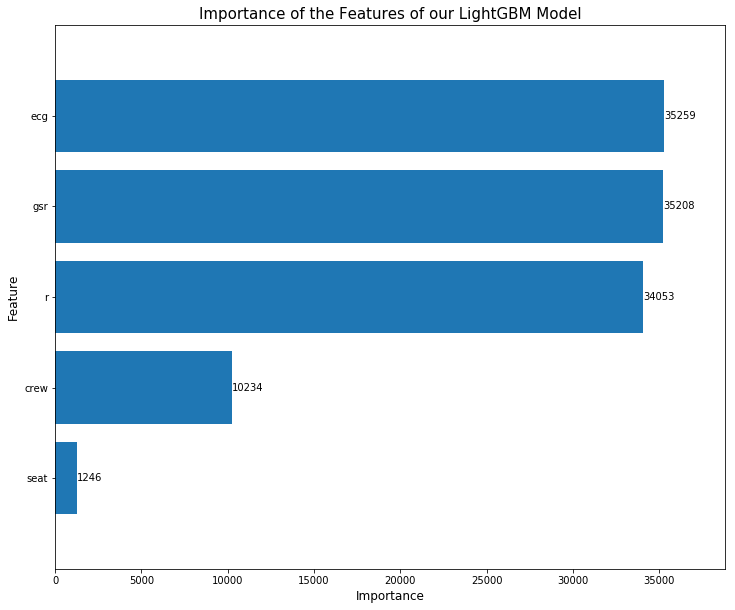

In [33]:
#看特徵重要重度
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2cc8291b160>)

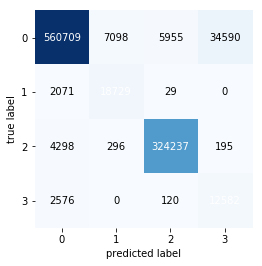

In [48]:
from sklearn.metrics import confusion_matrix

pred_val = model.predict(val_df[features], num_iteration=model.best_iteration)

from mlxtend.plotting import plot_confusion_matrix

conf_mat_val = confusion_matrix(np.argmax(pred_val, axis=1), val_df["event"].values)
plot_confusion_matrix(conf_mat_val, ["0", "1", "2", "3"])

In [34]:
pred_test = model.predict(test[features], num_iteration=model.best_iteration)    #預測

In [ ]:
#輸出檔案
submission = pd.DataFrame(np.concatenate((np.arange(len(test))[:, np.newaxis], pred_test), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
submission['id'] = submission['id'].astype(int)

In [ ]:
submission.head()

In [ ]:
submission.to_csv("R_submission.csv", index=False)